## Purpose

This code implements an automated fraud analysis system that processes customer fraud inquiry documents using AI-powered classification and risk assessment. The system leverages LangChain, OpenAI GPT models, and LangGraph to create a comprehensive workflow that ingests text documents, extracts fraud-related information using a predefined taxonomy, applies business rules for risk scoring, and generates structured reports in both JSON and CSV formats.

It designed for easy extensibility and future enhancements. While the current implementation follows a straightforward linear workflow, the LangGraph framework enables seamless addition of complex features.

## Use Cases

### Financial Institution Fraud Departments
- Scenario: A bank receives hundreds of fraud complaints daily via email, phone transcripts, and web forms.
- Application: Automatically categorize incoming reports, identify high-priority cases (large monetary losses, urgent language), and route them to appropriate specialists
- Benefit: Reduces initial triage time from hours to minutes, ensures critical cases aren't missed in high-volume periods

### Customer Service Operations
- Scenario: Multi-channel customer complaints about fraudulent activities need consistent handling regardless of source.
- Application: Process complaints from various channels (chat logs, emails, call transcripts) into standardized format for case management systems
- Benefit: Ensures consistent service quality, reduces response time for urgent cases

## Key Components

### Fraud Taxonomy Schema. 
- A comprehensive classification system with 7 main categories (Digital Fraud, Payment Fraud, Identity Fraud, Account Takeover, Card Fraud, Social Engineering, Internal Fraud), each with specific subcategories and associated channels, ensuring consistent fraud classification.

### FrudAnalysisState Model: 
- A Pydantic-based data model that maintains all relevant information throughout the processing pipeline, including document content, extracted fraud details, risk assessments, and processing metadata.

### LangGraph Workflow: 
- LangGraph Workflow: A state-driven processing pipeline with four main nodes - document ingestion, comprehensive AI analysis, business rule application, and report generation

### Comprehensive Analysis Engine. 
- A prompt-engineered system that uses structured output to extract fraud types, monetary impact, urgency indicators, and risk scores while strictly adhering to the predefined taxonomy relationships.

### Business Rules Engine.
- Automated risk scoring logic that combines urgency indicators and monetary impact to classify cases as Low, Medium, or High risk, with automatic flagging for human review based on ambiguous classifications or high-risk scenarios.

## Conclusion

This fraud analysis system provides a scalable, consistent approach to processing fraud inquiries that combines the power of large language models with structured business logic. By automating the initial classification and risk assessment phases, organizations can significantly improve their fraud response times while ensuring human experts focus their attention on the most critical and complex cases requiring manual intervention.

## 1. Setup & Dependencies

In [1]:
# !pip install pydantic langchain_openai python-dotenv langgraph
from typing import Optional, List, Dict, Any
from pydantic import BaseModel, Field
from pathlib import Path
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os
from typing import Literal
from datetime import datetime
import json, csv, glob

# Load environment variables
load_dotenv()

# Initialize LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# 2.  Fraud Taxonomy

In [2]:
# =============================
# Fraud Taxonomy Schema
# =============================
from pydantic import BaseModel
from typing import List, Optional

class FraudTaxonomy(BaseModel):
    category: str
    subcategory: List[str]
    channels: List[str]

FRAUD_TAXONOMY: List[FraudTaxonomy] = [
    FraudTaxonomy(
        category="Digital Fraud",
        subcategory=["Phishing", "SMiShing", "Vishing", "Malware", "Remote Access Tools (RAT)", "Fake Mobile Apps"],
        channels=["Email", "SMS", "Phone Call", "Mobile Banking App", "Web Banking", "Social Media"]
    ),
    FraudTaxonomy(
        category="Payment Fraud",
        subcategory=["Authorized Push Payment (APP) Fraud", "Fake Invoices", "Interception of Payment Instructions", "Stolen Credentials"],
        channels=["Email", "Web Banking", "Mobile Banking App", "P2P Payment App", "Call Center"]
    ),
    FraudTaxonomy(
        category="Identity Fraud",
        subcategory=["Synthetic Identity", "Stolen Identity", "Forged Documents", "Deepfake ID"],
        channels=["Account Opening Portal", "Loan Application", "Mobile App", "In-Branch"]
    ),
    FraudTaxonomy(
        category="Account Takeover",
        subcategory=["Credential Stuffing", "SIM Swap", "Device Cloning", "Social Engineering"],
        channels=["Mobile Banking App", "Web Banking", "Call Center", "Email", "Social Media", "Phone Call"]
    ),
    FraudTaxonomy(
        category="Card Fraud",
        subcategory=["Skimming", "Counterfeit Card", "Lost/Stolen Card Use", "Card Not Present (CNP) Fraud"],
        channels=["POS Terminal", "ATM", "Online Store / Merchant", "Mobile Wallet"]
    ),
    FraudTaxonomy(
        category="Social Engineering",
        subcategory=["Romance Scam", "Tech Support Scam", "CEO Fraud", "Impersonation"],
        channels=["Email", "Phone Call", "Messaging Apps", "Social Media"]
    ),
    FraudTaxonomy(
        category="Internal Fraud",
        subcategory=["Unauthorized Access", "Data Theft", "Transaction Manipulation", "Bribery or Kickbacks"],
        channels=["Internal Systems", "Branch Operations", "Call Center"]
    )
]

## 2. FraudData Schema

In [3]:
class FraudAnalysisState(BaseModel):
    """Single comprehensive state model for fraud analysis"""
    
    # File and document info
    source_path: Optional[str] = None  
    file_path: Optional[str] = None    
    raw_text: Optional[str] = None
    
    # LLM extracted fields
    summary: Optional[str] = Field(default=None, description="Brief summary of the fraud inquiry")
    fraud_types: List[FraudTaxonomy] = Field(default_factory=list, description="List of extracted fraud types with category, subcategory, and channels")
    monetary_impact: Optional[float] = Field(default=None, description="Estimated monetary impact")
    urgency: bool = Field(default=False, description="Whether case requires urgent attention base on the timestamp sensitivity")
    extraction_reason: Optional[str] = Field(default=None, description="Explanation for classification")
    
    # Computed fields
    risk_score: Literal["Low", "Medium", "High"] = "Low"
    needs_human_review: bool = False
    processing_timestamp: str = ""


## 3. Core Functions

In [4]:
def document_ingestion(state: FraudAnalysisState) -> FraudAnalysisState:
    """Load document content from file"""
    path = Path(state.file_path)
    with open(path, 'r', encoding='utf-8') as f:
        state.raw_text = f.read()
    return state

def generate_taxonomy_representation() -> str:
    """Generate a clear, hierarchical representation of the fraud taxonomy"""
    taxonomy_str = "FRAUD TAXONOMY - VALID RELATIONSHIPS ONLY:\n\n"
    
    for i, tax in enumerate(FRAUD_TAXONOMY, 1):
        taxonomy_str += f"🔹 {tax.category.upper()}\n"
        
        subcategories = " | ".join(tax.subcategory)
        taxonomy_str += f"   Subcategories: {subcategories}\n"
        
        channels = " | ".join(tax.channels)
        taxonomy_str += f"   Channels: {channels}\n"
        
        if i < len(FRAUD_TAXONOMY):
            taxonomy_str += "\n"
    
    taxonomy_str += "\nCRITICAL: Each fraud_types object must only contain subcategories and channels that belong to the same category. Cross-category mixing is INVALID."
    
    return taxonomy_str

def comprehensive_analysis(state: FraudAnalysisState) -> FraudAnalysisState:
    """Single LLM call to extract all information at once, using structured output and explicit taxonomy guidance."""
    
    # Use the hierarchical taxonomy representation
    taxonomy_section = generate_taxonomy_representation()

    prompt = f'''
You are an expert fraud analyst. Analyze the following fraud inquiry document and extract ALL the requested information related to categories, subcategories and channels. 

{taxonomy_section}

STRICT VALIDATION RULES:

1. CATEGORY VALIDATION:
   - ONLY use categories that exist exactly in the taxonomy above
   - Valid categories are: "Digital Fraud", "Payment Fraud", "Identity Fraud", "Account Takeover", "Card Fraud", "Social Engineering", "Internal Fraud"
   - If no category matches, use "Unknown"
   - NEVER create new categories or modify existing names

2. SUBCATEGORY VALIDATION:
   - ONLY use subcategories that belong to the selected category
   - Each subcategory has a specific parent category - respect this relationship
   - If fraud matches a category but no subcategory fits, use "Unknown"
   - NEVER mix subcategories from different categories in a single fraud_types object

3. CHANNEL VALIDATION:
   - ONLY use channels that are valid for the selected category
   - Each channel list is specific to its parent category
   - If channel isn't listed for that category, use "Unknown"
   - NEVER mix channels from different categories in a single fraud_types object

4. MULTIPLE FRAUD TYPES:
   - If incident involves multiple fraud categories, create SEPARATE fraud_types objects
   - Each fraud_types object must maintain category-subcategory-channel consistency

5. UNKNOWN/AMBIGUOUS VALUES:
   - Use "Unknown" when category/subcategory/channel cannot be determined
   - Use "Ambiguous" when multiple options seem equally likely within same category

6. ERROR PREVENTION:
   - Do NOT assume relationships - always check the taxonomy
   - Do NOT use partial matches (e.g., "Phish" instead of "Phishing")
   - Do NOT create hybrid categories or subcategories
   - Do NOT default to the most common fraud type if it doesn't match the evidence

7. URGENCY AND MONETARY IMPACT:
   - For urgency: True if client language indicates immediate need (words like "immediately", "ASAP", "help now", etc.)
   - For monetary_impact: Extract numeric value if mentioned, otherwise null
   - Keep extraction_reason concise (1-2 sentences max)

IMPORTANT: Return your response as a valid JSON object with these exact fields:

{{
  "summary": "Brief 1-2 sentence summary of the inquiry",
  "fraud_types": [
    {{
      "category": "Category from taxonomy",
      "subcategory": ["List of subcategories for this category"],
      "channels": ["List of channels for this category"]
    }}
    // ... (one object per fraud type detected)
  ],
  "monetary_impact": numeric_value_or_null,
  "urgency": true_or_false,
  "risk_score": "Low" or "Medium" or "High",
  "needs_human_review": true_or_false,
  "extraction_reason": "Brief 1-2 sentence explanation for your classifications"
  processing_timestamp: "Current timestamp in ISO format"
}}

VALIDATION CHECKLIST (Internal Check). Before finalizing your response, verify:
- Each category used exists in the taxonomy
- Each subcategory belongs to its paired category
- Each channel belongs to its paired category

EXAMPLES:

Example 1: Single Category - Digital Fraud
Document: "I received a suspicious email claiming to be from my bank asking me to click a link and enter my login details. I'm worried it might be a scam."
Response:
{{
  "summary": "Customer received suspicious email impersonating bank requesting login credentials, potential phishing attempt.",
  "fraud_types": [
    {{
      "category": "Digital Fraud",
      "subcategory": ["Phishing"],
      "channels": ["Email"]
    }}
  ],
  "monetary_impact": null,
  "urgency": false,
  "risk_score": "Low",
  "needs_human_review": false,
  "extraction_reason": "Classic phishing attempt via email, no monetary loss reported, no urgency indicators.",
  "processing_timestamp": "Current timestamp in ISO format"
}}

Example 2: Multiple Categories - Complex Fraud Chain
Document: "Help! Someone called pretending to be tech support, made me download remote access software, then they logged into my online banking and transferred $5,000 to another account. This happened this morning and I need help immediately!"
Response:
{{
  "summary": "Customer fell victim to tech support scam involving remote access software and unauthorized online banking transfer of $5,000.",
  "fraud_types": [
    {{
      "category": "Social Engineering",
      "subcategory": ["Tech Support Scam"],
      "channels": ["Phone Call"]
    }},
    {{
      "category": "Digital Fraud",
      "subcategory": ["Remote Access Tools (RAT)"],
      "channels": ["Web Banking"]
    }},
    {{
      "category": "Payment Fraud",
      "subcategory": ["Stolen Credentials"],
      "channels": ["Web Banking"]
    }}
  ],
  "monetary_impact": 5000.0,
  "urgency": true,
  "risk_score": "Medium",
  "needs_human_review": true,
  "extraction_reason": "Multi-stage fraud: social engineering led to RAT installation, enabling credential theft and unauthorized transfer. Urgency indicated by 'immediately' and 'help'."
  "processing_timestamp": "Current timestamp in ISO format"
}}

Example 3: Using "Unknown" Values
Document: "Someone used my card details to make purchases online, but I'm not sure how they got my information. The transactions were for $300 total."
Response:
{{
  "summary": "Customer reports unauthorized online card transactions totaling $300, source of compromise unknown.",
  "fraud_types": [
    {{
      "category": "Card Fraud",
      "subcategory": ["Unknown"],
      "channels": ["Online Store / Merchant"]
    }}
  ],
  "monetary_impact": 300.0,
  "urgency": false,
  "risk_score": "Low",
  "needs_human_review": false,
  "extraction_reason": "Card fraud confirmed via online transactions, but method of compromise cannot be determined from available information.",
  "processing_timestamp": "Current timestamp in ISO format"
}}

Example 4: SMiShing vs Fake Mobile Apps (Correct Classification)
Document: "I got a text message asking me to update my banking app by clicking a link. It looked suspicious so I didn't click it."
Response:
{{
  "summary": "Customer received suspicious SMS with link claiming to be bank app update, correctly identified as potential fraud.",
  "fraud_types": [
    {{
      "category": "Digital Fraud",
      "subcategory": ["SMiShing"],
      "channels": ["SMS"]
    }}
  ],
  "monetary_impact": null,
  "urgency": false,
  "risk_score": "Low",
  "needs_human_review": false,
  "extraction_reason": "SMiShing attempt via SMS, customer avoided the fraud, no monetary impact.",
  "processing_timestamp": "Current timestamp in ISO format"
}}

Example 5: Account Takeover - Ambiguous Method
Document: "My account was accessed without my permission and money was transferred out. I think someone might have my password."
Response:
{{
  "summary": "Unauthorized account access and money transfer, suspected credential compromise.",
  "fraud_types": [
    {{
      "category": "Account Takeover",
      "subcategory": ["Ambiguous"],
      "channels": ["Web Banking"]
    }}
  ],
  "monetary_impact": null,
  "urgency": false,
  "risk_score": "Low",
  "needs_human_review": false,
  "extraction_reason": "Account takeover evident from unauthorized access, but specific method unclear - could be credential stuffing, social engineering, or other means.",
  "processing_timestamp": "Current timestamp in ISO format"
}}

Example 6: Romance Scam - Social Engineering
Document: "I met someone online who claimed to love me and asked for money for an emergency. I sent $10,000 before realizing it was a scam. Please help me recover this!"
Response:
{{
  "summary": "Customer fell victim to romance scam, sent $10,000 to fraudster claiming emergency.",
  "fraud_types": [
    {{
      "category": "Social Engineering",
      "subcategory": ["Romance Scam"],
      "channels": ["Social Media"]
    }}
  ],
  "monetary_impact": 10000.0,
  "urgency": false,
  "risk_score": "Medium",
  "needs_human_review": true,
  "extraction_reason": "Classic romance scam via social media platform, significant monetary loss but no time-sensitive urgency indicators.",
  "processing_timestamp": "Current timestamp in ISO format"
}}

Example 7: Internal Fraud - Multiple Subcategories
Document: "I suspect one of our employees has been accessing customer accounts without authorization and may be stealing funds. This needs investigation."
Response:
{{
  "summary": "Suspected employee unauthorized access to customer accounts with potential fund theft.",
  "fraud_types": [
    {{
      "category": "Internal Fraud",
      "subcategory": ["Unauthorized Access", "Transaction Manipulation"],
      "channels": ["Internal Systems"]
    }}
  ],
  "monetary_impact": null,
  "urgency": false,
  "risk_score": "Low",
  "needs_human_review": false,
  "extraction_reason": "Internal fraud involving unauthorized access and potential transaction manipulation by employee through internal systems.",
  "processing_timestamp": "Current timestamp in ISO format"
}}

Example 8: Card Skimming at ATM
Document: "I used an ATM yesterday and today I see unauthorized charges on my card. The ATM looked normal but I'm wondering if it was compromised."
Response:
{{
  "summary": "Customer suspects ATM skimming after unauthorized charges appeared following ATM use.",
  "fraud_types": [
    {{
      "category": "Card Fraud",
      "subcategory": ["Skimming"],
      "channels": ["ATM"]
    }}
  ],
  "monetary_impact": null,
  "urgency": false,
  "risk_score": "Low",
  "needs_human_review": false,
  "extraction_reason": "ATM skimming suspected based on timing of unauthorized charges after ATM use, monetary impact not specified.",
  "processing_timestamp": "Current timestamp in ISO format"
}}

Example 9: Common Mistake - Wrong Category for Subcategory
Document: "Someone called saying they were from my bank and asked for my PIN. I gave it to them and now money is missing from my account."
CORRECT Response:
{{
  "summary": "Customer fell victim to voice phishing attack resulting in PIN compromise and monetary loss.",
  "fraud_types": [
    {{
      "category": "Digital Fraud",
      "subcategory": ["Vishing"],
      "channels": ["Phone Call"]
    }}
  ],
  "monetary_impact": null,
  "urgency": false,
  "risk_score": "Low",
  "needs_human_review": false,
  "extraction_reason": "Vishing attack via phone call, PIN compromised leading to unauthorized account access.",
  "processing_timestamp": "Current timestamp in ISO format"
}}
Note: "Vishing" belongs to "Digital Fraud" category, NOT "Social Engineering" - always verify subcategory-category relationships in the taxonomy.

Example 10: Account Takeover - SIM Swap
Document: "My phone stopped working yesterday and today I can't access my banking app. I see transactions I didn't make. I think someone took over my phone number."
Response:
{{
  "summary": "Customer reports phone service disruption followed by unauthorized banking transactions, suspected SIM swap attack.",
  "fraud_types": [
    {{
      "category": "Account Takeover",
      "subcategory": ["SIM Swap"],
      "channels": ["Mobile Banking App"]
    }}
  ],
  "monetary_impact": null,
  "urgency": false,
  "risk_score": "Low",
    "needs_human_review": false,
  "extraction_reason": "SIM swap attack pattern evident from phone service loss followed by unauthorized mobile banking access.",
  "processing_timestamp": "Current timestamp in ISO format"
}}

Now analyze this document:
{state.raw_text}
'''

    # Use structured output with the FraudAnalysisState schema
    response = llm.with_structured_output(FraudAnalysisState).invoke(prompt)
    
    # The SDK will validate and return a FraudAnalysisState instance
    if isinstance(response, FraudAnalysisState):
        # Copy all fields from the structured output
        for field in response.__class__.model_fields: 
            setattr(state, field, getattr(response, field))
        state.processing_timestamp = datetime.now().isoformat()
    else:
        # Fallback if something goes wrong
        state.extraction_reason = "Failed to parse LLM response as structured output"
        state.needs_human_review = True
    
    return state

def apply_business_rules(state: FraudAnalysisState) -> FraudAnalysisState:
    """Apply business logic for risk scoring and human review flags"""

    # Risk scoring logic
    urgency = bool(state.urgency)
    monetary_impact = state.monetary_impact if state.monetary_impact is not None else 0

    if urgency and monetary_impact > 10000:
        state.risk_score = "High"
    elif urgency or monetary_impact > 10000:
        state.risk_score = "Medium"
    else:
        state.risk_score = "Low"
    
    # Human review detection
    has_flagged = False
    for fraud in state.fraud_types:
        if (
            fraud.category in ["Unknown", "Ambiguous"] or
            any(sc in ["Unknown", "Ambiguous"] for sc in fraud.subcategory) or
            any(ch in ["Unknown", "Ambiguous"] for ch in fraud.channels)
        ):
            has_flagged = True
            break
    # Human review flagging logic
    state.needs_human_review = (
        has_flagged or 
        state.risk_score == "High" or
        not state.extraction_reason  # If extraction failed
    )
    
    return state

def generate_report(state: FraudAnalysisState) -> Dict[str, Any]:
    """Generate final report, ensuring source_path and file_path are present, and removing raw_text."""
    output = state.model_dump()
    # Always include source_path and file_path
    output['source_path'] = state.source_path
    output['file_path'] = state.file_path
    # Remove raw_text from the output if present
    output.pop('raw_text', None)
    return output

## 4. LangGraph Workflow Definition

In [5]:
from langgraph.graph import StateGraph, START, END

# Define the simplified graph
fraud_graph = StateGraph(FraudAnalysisState)

# Add nodes
fraud_graph.add_node("ingest", document_ingestion)
fraud_graph.add_node("analyze", comprehensive_analysis)
fraud_graph.add_node("apply_rules", apply_business_rules)
fraud_graph.add_node("report", generate_report)

# Define flow - much simpler now
fraud_graph.add_edge(START, "ingest")
fraud_graph.add_edge("ingest", "analyze")
fraud_graph.add_edge("analyze", "apply_rules")
fraud_graph.add_edge("apply_rules", "report")
fraud_graph.add_edge("report", END)

fraud_graph = fraud_graph.compile()


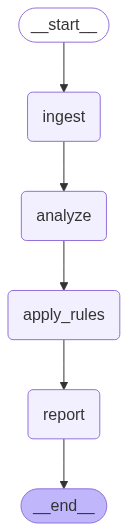

In [6]:
from IPython.display import Image, display

# Create and display the graph
display(Image(fraud_graph.get_graph(xray=True).draw_mermaid_png()))

## 5. Processing Functions 

In [7]:
def run_fraud_analysis(file_path: str) -> Dict[str, Any]:
    """Process a single fraud inquiry file using the graph"""
    source_path = os.path.basename(file_path)
    state = FraudAnalysisState(
        source_path=source_path,
        file_path=file_path
    )
    result = fraud_graph.invoke(state)  # One graph call per file
    # Ensure these fields are always set in the final state
    if isinstance(result, FraudAnalysisState):
        result.source_path = source_path
        result.file_path = file_path
    elif isinstance(result, dict):
        result['source_path'] = source_path
        result['file_path'] = file_path
    return result

def process_files_individually(claims_folder: str) -> List[Dict[str, Any]]:
    """Process files one by one (individual processing with batch appearance)"""
    txt_files = glob.glob(os.path.join(claims_folder, '*.txt'))
    results = []
    
    print(f"Found {len(txt_files)} files to process")
    print("=" * 50)
    
    # Batch processing loop - but each file processed individually
    for i, txt_file in enumerate(txt_files, 1):
        print(f"Processing ({i}/{len(txt_files)}): {os.path.basename(txt_file)}")
        
        try:
            # One graph execution per file
            result = run_fraud_analysis(txt_file)
            # Remove 'raw_text' if present before saving
            if isinstance(result, dict):
                result.pop('raw_text', None)
            results.append(result)
   
        except Exception as e:
            print(f"  → ❌ ERROR: {e}")
            # Add error result to maintain consistency
            error_result = {
                "source_path": os.path.basename(txt_file),
                "error": str(e),
                "needs_human_review": True,
                "risk_score": "High",
                "processing_timestamp": datetime.now().isoformat()
            }
            results.append(error_result)
        
        print()  # Empty line for readability
    
    return results

def export_results(results: List[Dict[str, Any]], output_dir: str):
    """Export results to JSON and CSV formats"""
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Export JSON
    json_path = os.path.join(output_dir, f'fraud_results_{timestamp}.json')
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    print(f"✅ Results saved as JSON: {json_path}")
    
    # Export CSV
    if results:
        csv_path = os.path.join(output_dir, f'fraud_results_{timestamp}.csv')
        # Get all possible keys from all results
        all_keys = sorted(set().union(*(r.keys() for r in results)))
        
        with open(csv_path, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=all_keys)
            writer.writeheader()
            writer.writerows(results)
        print(f"✅ Results saved as CSV: {csv_path}")

def print_summary(results: List[Dict[str, Any]]):
    """Print processing summary"""
    total = len(results)
    review_needed = sum(1 for r in results if r.get('needs_human_review', False))
    high_risk = sum(1 for r in results if r.get('risk_score') == 'High')
    errors = sum(1 for r in results if 'error' in r)
    
    print("=" * 50)
    print(f"📊 PROCESSING SUMMARY")
    print("=" * 50)
    print(f"Total files processed: {total}")
    print(f"Files needing human review: {review_needed}")
    print(f"High risk cases: {high_risk}")
    print(f"Processing errors: {errors}")
    print(f"Auto-processed successfully: {total - review_needed}")

## 6. Running the Pipeline

In [8]:
script_dir = os.path.dirname(os.path.abspath('Fraud_Classifier_with_taxonomy.ipynb'))
claims_folder = os.path.join(script_dir, 'Claims')
output_dir = os.path.join(script_dir, 'Output')
    
print(f"🔍 Looking for files in: {claims_folder}")

results = process_files_individually(claims_folder)
print_summary(results)
export_results(results, output_dir)
    
print("✅ Individual file processing complete!")

🔍 Looking for files in: C:\Users\Oscar\Documents\Python\Artificial_Inteligence\Workflows_Projects\Agents\Fraud_Claims_Classifier\Claims
Found 10 files to process
Processing (1/10): 001.txt

Processing (2/10): 002.txt

Processing (3/10): 003.txt

Processing (4/10): 004.txt

Processing (5/10): 005.txt

Processing (6/10): 006.txt

Processing (7/10): 007.txt

Processing (8/10): 008.txt

Processing (9/10): 009.txt

Processing (10/10): 010.txt

📊 PROCESSING SUMMARY
Total files processed: 10
Files needing human review: 4
High risk cases: 0
Processing errors: 0
Auto-processed successfully: 6
✅ Results saved as JSON: C:\Users\Oscar\Documents\Python\Artificial_Inteligence\Workflows_Projects\Agents\Fraud_Claims_Classifier\Output\fraud_results_20250727_173015.json
✅ Results saved as CSV: C:\Users\Oscar\Documents\Python\Artificial_Inteligence\Workflows_Projects\Agents\Fraud_Claims_Classifier\Output\fraud_results_20250727_173015.csv
✅ Individual file processing complete!


In [11]:
import os
import glob
import json

# Set your output directory path
output_dir = "Output"  # adjust this if your output folder is elsewhere

# Find the latest JSON results file
json_files = sorted(glob.glob(os.path.join(output_dir, 'fraud_results_*.json')), reverse=True)
if json_files:
    json_path = json_files[0]
    with open(json_path, 'r', encoding='utf-8') as f:
        loaded_results = json.load(f)
    if loaded_results:
        print("\n📄 Example result from JSON file:")
        print(json.dumps(loaded_results[0], indent=2, ensure_ascii=False))
    else:
        print("No results found in the JSON file.")
else:
    print("No JSON results file found to showcase.")


📄 Example result from JSON file:
{
  "source_path": "001.txt",
  "file_path": "C:\\Users\\Oscar\\Documents\\Python\\Artificial_Inteligence\\Workflows_Projects\\Agents\\Fraud_Claims_Classifier\\Claims\\001.txt",
  "summary": "Customer reports unauthorized charge of $1,250 to 'CryptoPay Ltd.', suspects card information compromise and requests investigation.",
  "fraud_types": [
    {
      "category": "Card Fraud",
      "subcategory": [
        "Card Not Present (CNP) Fraud"
      ],
      "channels": [
        "Online Store / Merchant"
      ]
    }
  ],
  "monetary_impact": 1250.0,
  "urgency": true,
  "extraction_reason": "Unauthorized charge indicates potential card information compromise, urgency indicated by immediate action taken to lock the card and request investigation.",
  "risk_score": "Medium",
  "needs_human_review": false,
  "processing_timestamp": "2025-07-27T17:29:33.875078"
}
